# Building a Simple Generator Network

## Overview

In this demo, we'll build a **basic generator network** that learns to map random noise into MNIST-like images. This is the foundation of all generative models - learning a function that transforms simple, easy-to-sample distributions (Gaussian noise) into complex, high-dimensional distributions (natural images).

### What You'll Learn
- How to design a generator architecture with PyTorch
- Why we use specific activation functions (LeakyReLU, Tanh)
- How to verify tensor shapes through the network
- How to sample and visualize generated outputs

### Key Concepts
- **Latent Space**: The low-dimensional space we sample from (e.g., 100D Gaussian)
- **Image Space**: The high-dimensional space we're mapping to (28×28 = 784D for MNIST)
- **Activation Functions**: LeakyReLU prevents dead neurons; Tanh constrains output to [-1, 1]

Let's build and test our first generator!

## Section 1: Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# alternatively check if device is mps and move to mps
if torch.backends.mps.is_available():
    device = torch.device("mps")
    

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
PyTorch version: 2.5.1+cu121


## Section 2: Load and Prepare the MNIST Dataset

Before we build the generator, let's load MNIST to understand what we're trying to generate. Each image is 28×28 pixels (784 values when flattened).

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.42MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Sample batch shape: torch.Size([64, 1, 28, 28])
Image dimensions: torch.Size([1, 28, 28])
Image flattened size: 784
Pixel range: [-1.000, 1.000]


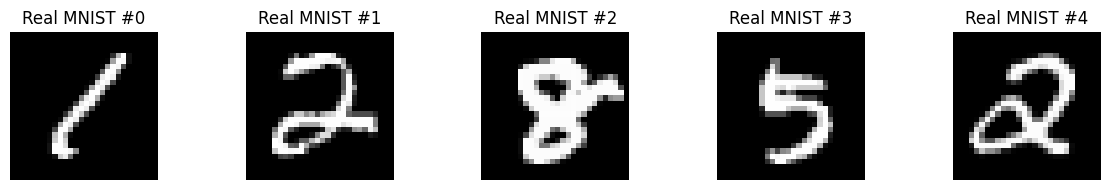

In [2]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, 
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

# Peek at a batch
sample_batch, _ = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Image dimensions: {sample_batch[0].shape}")
print(f"Image flattened size: {sample_batch[0].numel()}")
print(f"Pixel range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

# Visualize a few real MNIST images
fig, axes = plt.subplots(1, 5, figsize=(12, 2))
for i in range(5):
    img = sample_batch[i, 0].cpu().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Real MNIST #{i}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## Section 3: Define the Generator Network Architecture

Now let's build our generator. Here's our strategy:

1. **Input**: 100-dimensional noise vector (latent code)
2. **Hidden layers**: 256 → 256 (with LeakyReLU)
3. **Output**: 784-dimensional vector (28×28 flattened image)
4. **Final activation**: Tanh to constrain output to [-1, 1]

**Why LeakyReLU?** ReLU can suffer from "dying ReLU" problem where gradients become zero. LeakyReLU allows a small negative gradient.

**Why Tanh?** Our images are normalized to [-1, 1], and Tanh naturally outputs in this range.

In [3]:
class SimpleGenerator(nn.Module):
    """
    A simple fully-connected generator for MNIST.
    
    Maps 100D noise → 784D image (28x28)
    """
    def __init__(self, latent_dim=100, hidden_dim=256):
        super(SimpleGenerator, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim, 784),
            nn.Tanh()  # Output in [-1, 1]
        )
    
    def forward(self, z):
        """
        Args:
            z: noise tensor of shape (batch_size, latent_dim)
        
        Returns:
            img: generated image of shape (batch_size, 784)
        """
        return self.network(z)

# Instantiate the generator
latent_dim = 100
generator = SimpleGenerator(latent_dim=latent_dim)
generator = generator.to(device)

print("Generator architecture:")
print(generator)
print(f"\nTotal parameters: {sum(p.numel() for p in generator.parameters()):,}")


Generator architecture:
SimpleGenerator(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

Total parameters: 293,136


## Section 4: Verify Output Tensor Dimensions

Let's test the generator with a small batch to make sure tensor shapes flow correctly through the network. This is a critical debugging skill!

In [5]:
# Test with different batch sizes
batch_sizes = [1, 8, 16]

for batch_size in batch_sizes:
    test_noise = torch.randn(batch_size, latent_dim).to(device)
    test_output = generator(test_noise)
    
    print(f"\nBatch size: {batch_size}")
    print(f"  Input shape:  {test_noise.shape}")
    print(f"  Output shape: {test_output.shape}")
    print(f"  Expected:     torch.Size([{batch_size}, 784])")
    print(f"  ✓ Match!" if test_output.shape == (batch_size, 784) else "  ✗ Mismatch!")
    print(f"  Pixel range: [{test_output.min():.3f}, {test_output.max():.3f}]")

print("\n All tensor shapes verified!")



Batch size: 1
  Input shape:  torch.Size([1, 100])
  Output shape: torch.Size([1, 784])
  Expected:     torch.Size([1, 784])
  ✓ Match!
  Pixel range: [-0.285, 0.302]

Batch size: 8
  Input shape:  torch.Size([8, 100])
  Output shape: torch.Size([8, 784])
  Expected:     torch.Size([8, 784])
  ✓ Match!
  Pixel range: [-0.391, 0.377]

Batch size: 16
  Input shape:  torch.Size([16, 100])
  Output shape: torch.Size([16, 784])
  Expected:     torch.Size([16, 784])
  ✓ Match!
  Pixel range: [-0.402, 0.374]

 All tensor shapes verified!


## Section 5: Sample Noise Vectors from Gaussian Distribution

Now let's generate 16 random noise vectors. These will be our "seeds" for image generation. In a trained generator, different noise vectors produce different images. Here, since the generator is untrained, they'll all look like noise.

Sampled 16 noise vectors
Shape: torch.Size([16, 100])
Mean: -0.003
Std:  1.018
Range: [-3.625, 4.456]


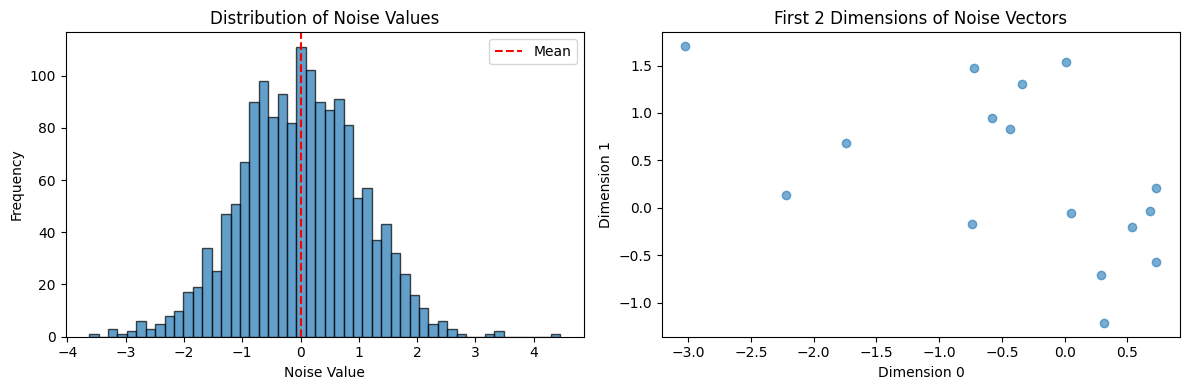

In [6]:
# Sample 16 noise vectors from standard normal distribution N(0, 1)
num_samples = 16
noise_vectors = torch.randn(num_samples, latent_dim).to(device)

print(f"Sampled {num_samples} noise vectors")
print(f"Shape: {noise_vectors.shape}")
print(f"Mean: {noise_vectors.mean():.3f}")
print(f"Std:  {noise_vectors.std():.3f}")
print(f"Range: [{noise_vectors.min():.3f}, {noise_vectors.max():.3f}]")

# Visualize the distribution of noise values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(noise_vectors.cpu().numpy().flatten(), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.title('Distribution of Noise Values')
plt.axvline(x=0, color='r', linestyle='--', label='Mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(noise_vectors[:, 0].cpu().numpy(), 
           noise_vectors[:, 1].cpu().numpy(), alpha=0.6)
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.title('First 2 Dimensions of Noise Vectors')
plt.tight_layout()
plt.show()


## Section 6: Generate Images from Random Noise

Now let's feed these noise vectors through our generator to create 16 images. Remember: the generator is untrained, so the output will look like random noise. Once we train it, it will learn to produce realistic digits!

In [8]:
# Generate images
generator.eval()  # Set to evaluation mode
with torch.no_grad():  # No gradients needed
    generated_images = generator(noise_vectors)

print(f"Generated images shape: {generated_images.shape}")
print(f"Expected shape: torch.Size([16, 784])")
print(f"Pixel value range: [{generated_images.min():.3f}, {generated_images.max():.3f}]")
print("\n Image generation successful!")


Generated images shape: torch.Size([16, 784])
Expected shape: torch.Size([16, 784])
Pixel value range: [-0.396, 0.425]

 Image generation successful!


## Section 7: Visualize Generated Images

Now let's reshape the flattened output (784 values) back into 28×28 images and display them in a grid. We'll also compare them side-by-side with real MNIST images.

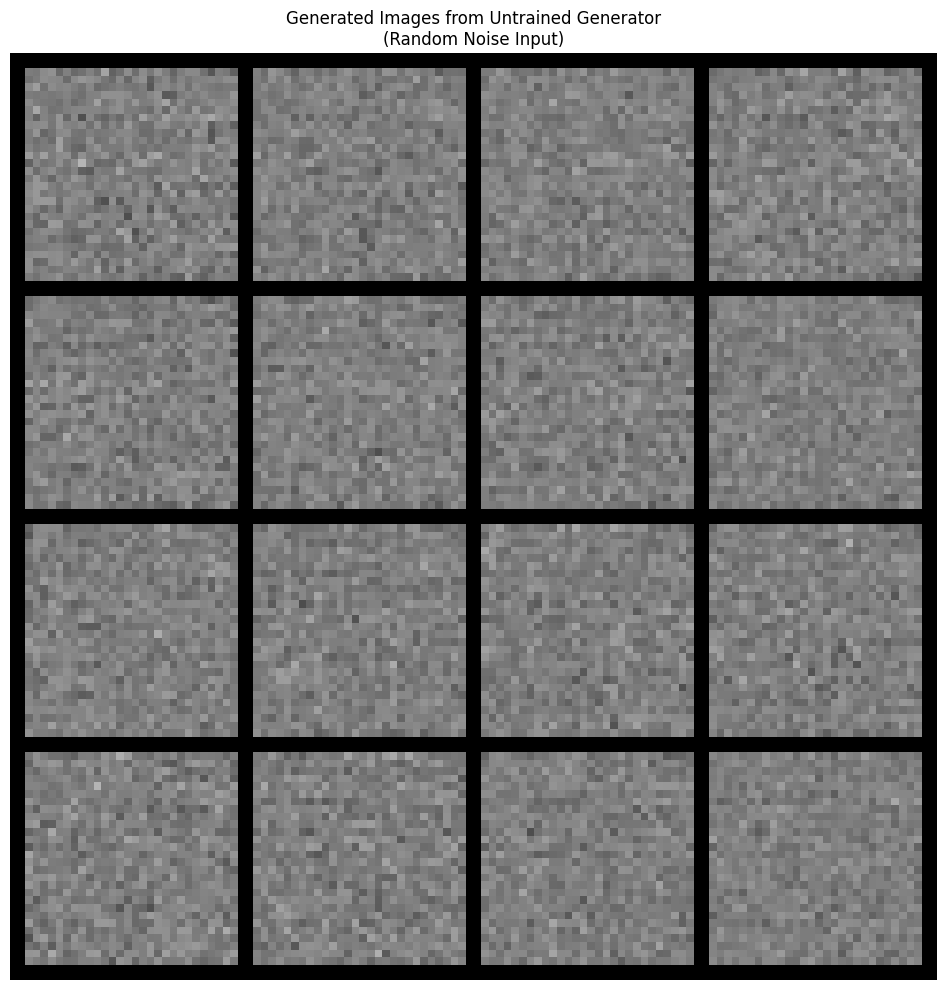

Displayed grid of 16 generated images
Grid shape: torch.Size([3, 122, 122])


In [9]:
# Reshape from (16, 784) to (16, 1, 28, 28)
generated_reshaped = generated_images.view(-1, 1, 28, 28)

# Denormalize from [-1, 1] to [0, 1] for display
generated_denorm = (generated_reshaped + 1) / 2

# Create grid using torchvision.utils.make_grid
grid = vutils.make_grid(generated_denorm, nrow=4, padding=2, normalize=False)

# Display the generated images
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title('Generated Images from Untrained Generator\n(Random Noise Input)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Displayed grid of {num_samples} generated images")
print(f"Grid shape: {grid.shape}")


## Section 8: Comparison - Real vs Generated Images

Let's place real MNIST images next to generated ones to highlight the difference. The real images have structure (digits), while the generated ones are pure noise since our generator isn't trained yet.

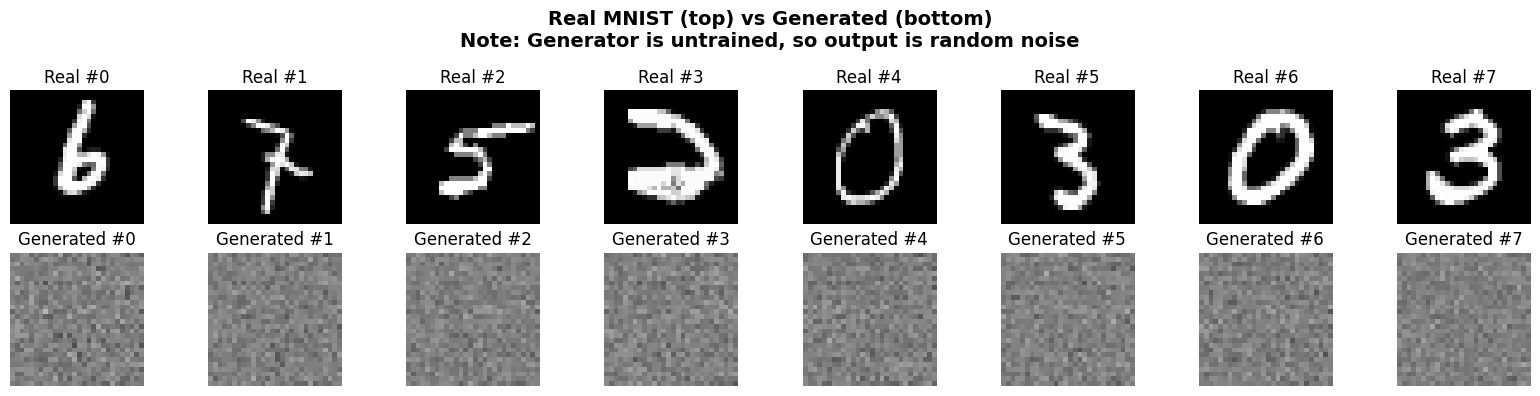

In [10]:
# Get a fresh batch of real images
real_batch, _ = next(iter(train_loader))
real_batch = real_batch[:num_samples].to(device)

# Create side-by-side comparison
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Real image
    real_img = real_batch[i, 0].cpu().numpy()
    axes[0, i].imshow(real_img, cmap='gray', vmin=-1, vmax=1)
    axes[0, i].set_title(f'Real #{i}')
    axes[0, i].axis('off')
    
    # Generated image
    gen_img = generated_denorm[i, 0].cpu().detach().numpy()
    axes[1, i].imshow(gen_img, cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Generated #{i}')
    axes[1, i].axis('off')

fig.suptitle('Real MNIST (top) vs Generated (bottom)\nNote: Generator is untrained, so output is random noise', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Key Takeaways

### What We've Built
 + A simple 3-layer fully-connected generator  
 + Properly configured activations (LeakyReLU → Tanh)  
 + Correct tensor shape handling (100D → 784D)  
 + Ability to sample and visualize generated images  

### What We Observe
- The generated images look like **random noise** because the generator is **untrained**
- Real MNIST images have clear structure (digits 0-9)
- The difference is dramatic - this shows why training matters!

### Next Steps
In the next phase, we'll:
1. Build a **Discriminator** to distinguish real from fake images
2. Train both together in an **adversarial process** (GAN)
3. Watch the generator gradually learn to produce realistic digits

The key insight: **We're learning a function that maps simple noise → complex images. This is the essence of generative modeling.**